In [10]:
# python
import json
import argparse
from subprocess import PIPE
from subprocess import Popen
import pandas as pd
import base64
from PIL import Image
from io import BytesIO
import numpy as np

import sys

# python
import time
import datetime

# python
import ast
import random, string
import os
from time import gmtime, strftime 

from sentence_transformers import SentenceTransformer, util, models
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
from tqdm.autonotebook import tqdm

#import img2pdf

from matplotlib import image
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2 as cv

In [11]:
torch.set_num_threads(16)

#First, we load the respective CLIP model
clip_model = models.CLIPModel()
model = SentenceTransformer(modules=[clip_model])
#model = SentenceTransformer('clip-ViT-B-32')

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [12]:
def convert_base64_to_array(base64_in):
    image_bytearray = bytearray(base64.b64decode(base64_in))
    output = Image.open(BytesIO(image_bytearray))
    
    return output

In [13]:
files_ = list(glob.glob('/dfs/user/apan0008/NEW/raw_fred/*/*.json'))
data_raw = pd.DataFrame()

for file in files_:
    data = pd.read_json(file, lines=True)
    data_raw = data_raw.append(data, ignore_index = True)
    
data_raw = data_raw[(~pd.isnull(data_raw['imageBytes'])) & (data_raw['lcid'] == '17f48df6c639413aa8b47c87c85252d7')]
data_raw.reset_index(inplace=True, drop=True)

# combine with t_image_recipes table
t_image_scores = pd.read_parquet('/dfs/user/apan0008/NEW/dout_fred2/T_IMAGE_RECIPES/')
t_image_scores_fred = t_image_scores[t_image_scores['LCID'] == '17f48df6c639413aa8b47c87c85252d7']

data_raw = data_raw[data_raw['checkSum'].isin(t_image_scores_fred['CHECKSUM'])]

# convert to array
convert_func = lambda x: convert_base64_to_array(x)
data_raw['image_array'] = data_raw['imageBytes'].apply(convert_func)
data_raw.reset_index(inplace=True, drop=True)

In [5]:
# image embedding

img_emb = model.encode([x for x in data_raw['image_array']], batch_size=128, 
                       convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

In [6]:
# We have implemented our own, efficient method
# to find high density regions in vector space
def community_detection(embeddings, threshold, min_community_size=10, init_max_size=1000):
    """
    Function for Fast Community Detection

    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).

    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

In [7]:
community_size = np.min((5,len(img_emb)))
print(community_size)
clusters = community_detection(img_emb, threshold=0.9, min_community_size=community_size)
print("Total number of clusters:", len(clusters))

5
Total number of clusters: 139


In [13]:
emb_filename = 'unsplash-25k-photos-embeddings.pkl'
if not os.path.exists(emb_filename):   #Download dataset if does not exist
    util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)

with open(emb_filename, 'rb') as fIn:
    img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))

Images: 24996


In [8]:
def plot_cluster(df_in, cluster_indexes):

    fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(50, 50), sharex=True, sharey=True)
    counter = 0
    for image_ind in cluster_indexes[0:48]:

        ax = axes.flatten()[counter]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('auto')
        ax.imshow(df_in.loc[image_ind,'image_array'])

        counter += 1
    
    plt.subplots_adjust(wspace=0, hspace=0)  

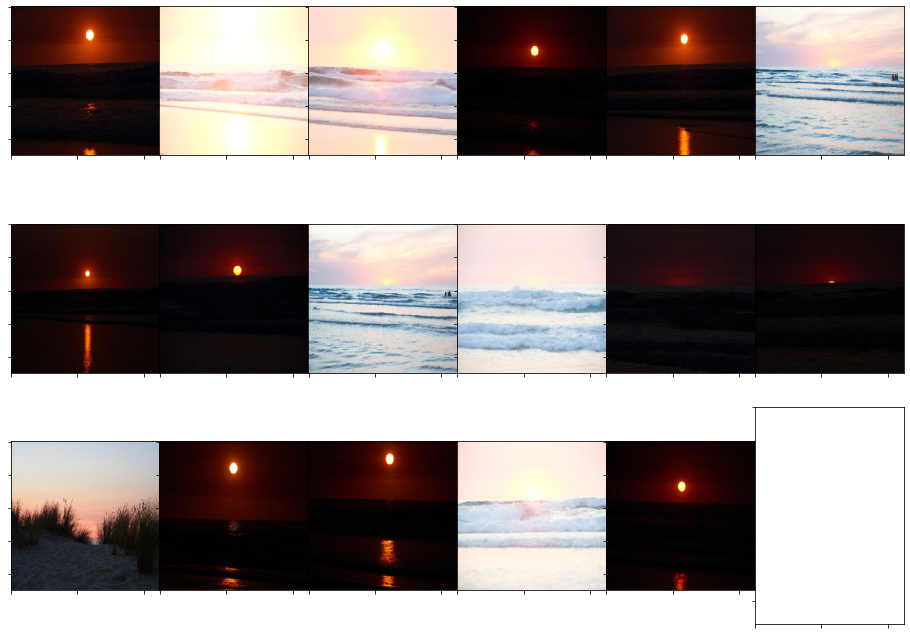

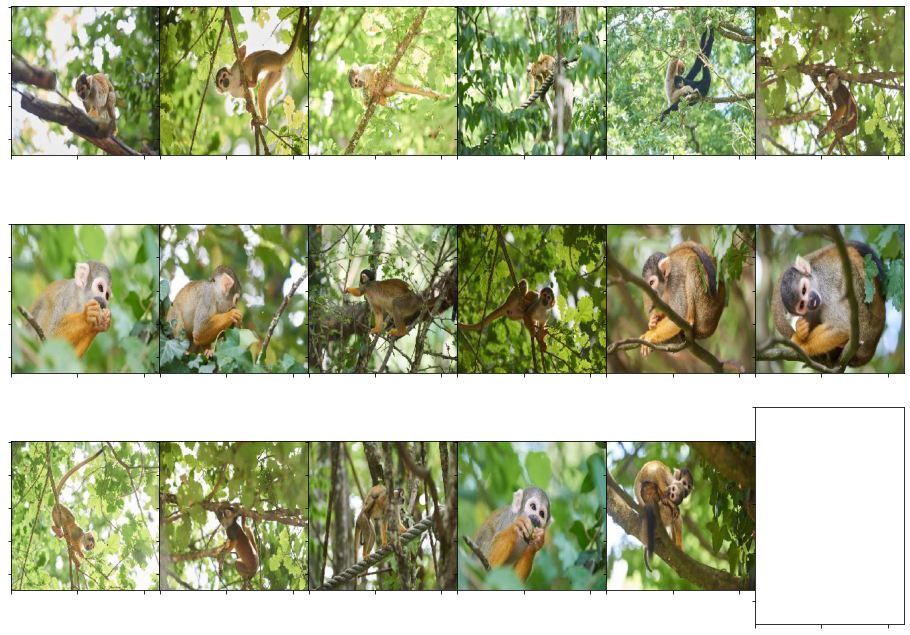

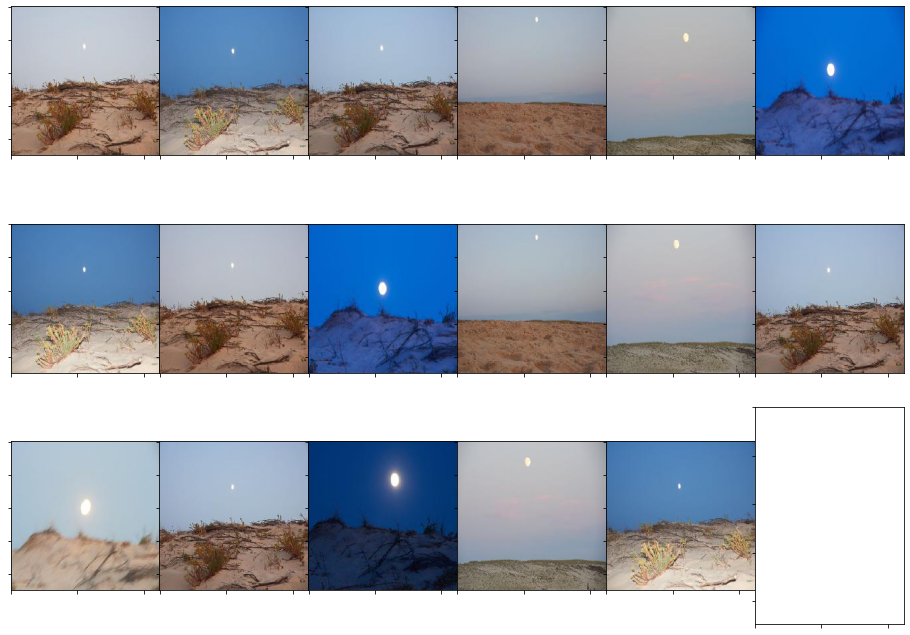

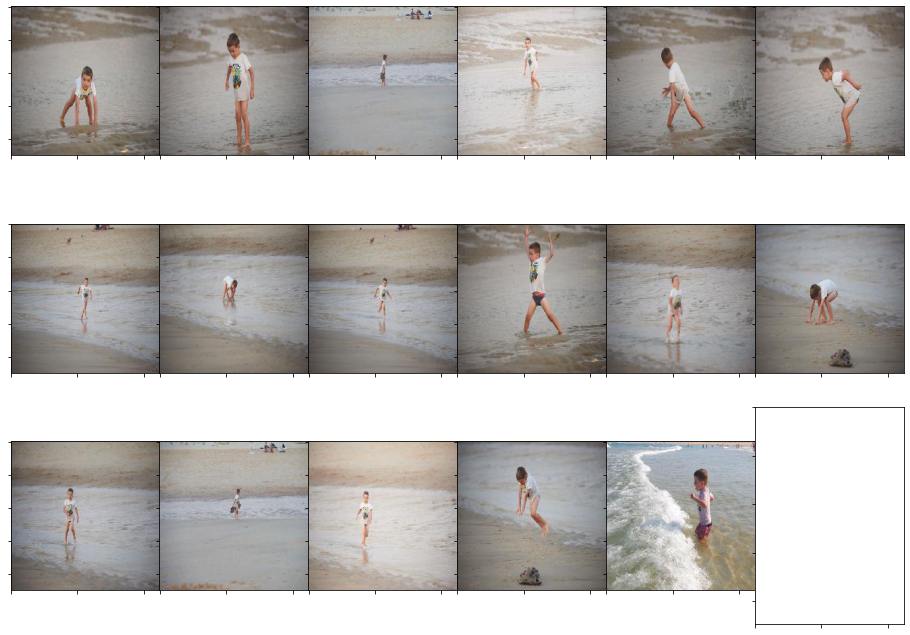

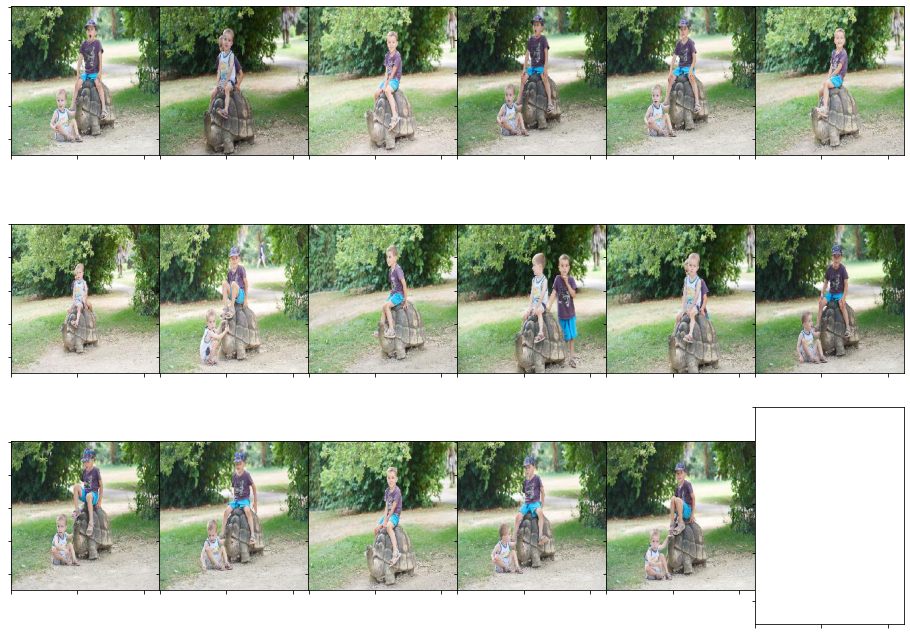

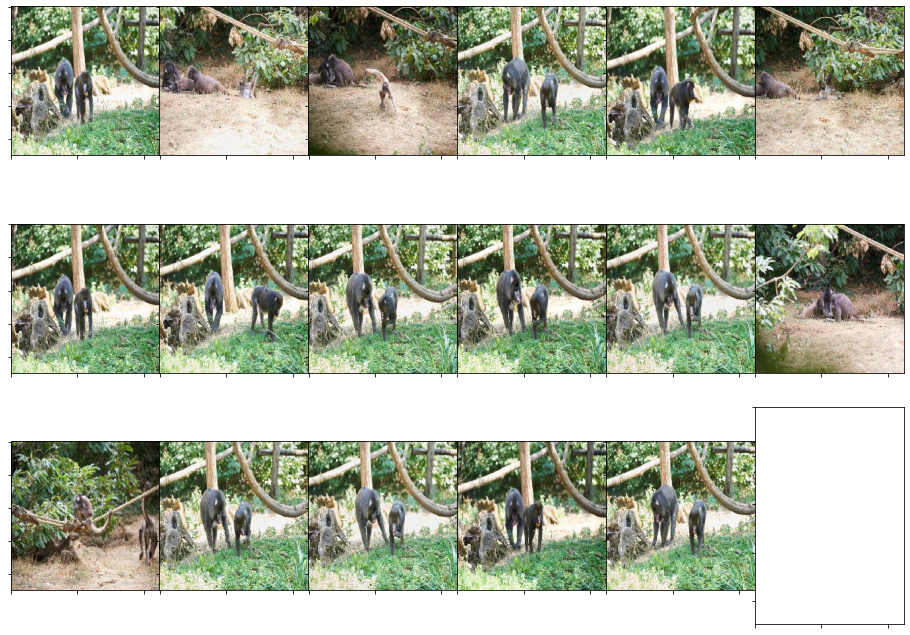

In [9]:
for cluster in clusters[0:6]:
    #print("\n\nCluster size:", len(cluster))
    counter = 0
    #Output 7 images
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(16, 12), sharex=True, sharey=True)
    for image_ind in cluster[-17:]:
        ax = axes.flatten()[counter]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('auto')
        ax.imshow(data_raw.loc[image_ind,'image_array'])
        fig.show()
        counter += 1
    plt.subplots_adjust(wspace=0, hspace=0)  